In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
%matplotlib inline

def print_score(y_pred, y_real, y_score, label_encoder, model_name):
    data = []

    data.append(["Accuracy", accuracy_score(y_real, y_pred)])
    data.append(["Precision (macro)", precision_score(y_real, y_pred, average='macro', zero_division=1)])
    data.append(["Recall (macro)", recall_score(y_real, y_pred, average='macro', zero_division=0)])
    data.append(["F1-score (macro)", f1_score(y_real, y_pred, average='macro', zero_division=0)])
    data.append(["AUC-ROC (macro)", roc_auc_score(y_real, y_score, multi_class='ovr', average='macro')])

    for i in range(len(label_encoder.classes_)):
        class_name = label_encoder.inverse_transform([i])[0]
        data.append([f"Precision ({class_name})", precision_score(y_real, y_pred, labels=[i], average='weighted', zero_division=1)])
        data.append([f"Recall ({class_name})", recall_score(y_real, y_pred, labels=[i], average='weighted', zero_division=0)])
        data.append([f"F1-score ({class_name})", f1_score(y_real, y_pred, labels=[i], average='weighted', zero_division=0)])

    score_df = pd.DataFrame(data, columns=["Metric", "Value"])
    display(score_df)

    # Save the score DataFrame to a CSV file
    score_df.to_csv(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_metrics.csv", index=False)


def plot_roc_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)

    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 6))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_roc_curve.png", bbox_inches='tight')  # Move this line before plt.show()
        plt.show()
    else:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:, i], pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 6))
        for i in range(n_classes):
            class_name = label_encoder.inverse_transform([i])[0]
            plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_name, roc_auc[i]))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_roc_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()


from sklearn.metrics import PrecisionRecallDisplay

def plot_precision_recall_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)

    if n_classes == 2:
        precision, recall, _ = precision_recall_curve(y_true, y_score[:, 1])
        average_precision = average_precision_score(y_true, y_score[:, 1])

        plt.figure(figsize=(10, 6))  # Change the figure size here
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_precision_recall_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()
    else:
        y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))
        precision = dict()
        recall = dict()
        average_precision = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_true_binarized[:, i], y_score[:, i], average=None)

        # Plot Precision-Recall curve for each class
        plt.figure(figsize=(10, 6))  # Change the figure size here
        for i in range(n_classes):
            disp = PrecisionRecallDisplay(precision=precision[i], recall=recall[i])
            class_name = label_encoder.inverse_transform([i])[0]
            disp.plot(ax=plt.gca(), label='Precision-recall curve of class {0} (AP = {1:0.2f})'.format(class_name, average_precision[i]))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_precision_recall_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()

def plot_class_accuracy(y_true, y_pred, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    class_counts = np.zeros(n_classes)
    class_corrects = np.zeros(n_classes)

    for t, p in zip(y_true, y_pred):
        class_counts[t] += 1
        if t == p:
            class_corrects[t] += 1

    class_accuracies = class_corrects / class_counts
    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_accuracies)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_class_accuracy.png", bbox_inches='tight')  # Move this line before plt.show()
    plt.show()

def plot_class_f1_score(y_true, y_pred, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    f1_scores = []

    for i in range(n_classes):
        class_f1_score = f1_score(y_true, y_pred, labels=[i], average='weighted')
        f1_scores.append(class_f1_score)

    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, f1_scores)
    plt.xlabel('Class')
    plt.ylabel('F1-score')
    plt.title('F1-score per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    fig = plt.gcf()  # Get the current figure
    plt.show()

    # Save the figure to an image file
    fig.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_class_f1_score.png", bbox_inches='tight')

# Load the dataset
file_path = '/content/drive/MyDrive/UNSW_NB15_training-set.csv'
df = pd.read_csv(file_path)


In [ ]:
print(df['attack_cat'].value_counts())

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64


In [5]:
import tensorflow as tf

embedding_size = 128  # Choose the desired embedding size
X = df.iloc[:, :-1]  # Get all columns except the last one as input features
num_features = X.shape[1]
num_samples = X.shape[0]  # Get the number of samples

# Define the input and embedding layer
input_features = tf.keras.layers.Input(shape=(num_features,))
embedding_layer = tf.keras.layers.Dense(embedding_size, activation='relu')
embeddings = embedding_layer(input_features)

# Positional encoding functions
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    pos_encoding = np.zeros((position, d_model), dtype=np.float32)
    pos_encoding[0::2, :] = np.sin(angle_rads[0::2, :])
    pos_encoding[1::2, :] = np.cos(angle_rads[1::2, :])
    return tf.cast(pos_encoding, dtype=tf.float32)

# Add positional encoding to the embeddings
position = num_features  # Number of positions equal to the number of samples
embeddings_with_pos_enc = positional_encoding(position, embedding_size) + embeddings

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE


def position_wise_feed_forward(inputs, d_ff):
    x = Dense(units=d_ff, activation='relu')(inputs)
    x = Dense(units=d_model)(x)
    return x

def multi_head_self_attention(inputs, d_model, num_heads, dropout_rate):
    depth = d_model // num_heads
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=depth, dropout=0.3)
    x = attention(inputs, inputs)
    return x

def encoder_layer(inputs, d_model, num_heads, d_ff, dropout_rate=0.3):
    x = multi_head_self_attention(inputs, d_model, num_heads, dropout_rate)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)

    ff = position_wise_feed_forward(x, d_ff)
    x = Dropout(dropout_rate)(ff)
    x = LayerNormalization(epsilon=1e-6)(x + ff)

    return x

class BroadcastPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(BroadcastPositionalEncoding, self).__init__()
        self.pos_encoding = positional_encoding(position, d_model)

    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.pos_encoding[:shape[0], :shape[1]]

def create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes, dropout_rate=0.3):
    inputs = Input(shape=input_shape)

    # Embedding layer
    embedding_layer = Dense(d_model, activation='relu')
    embeddings = embedding_layer(inputs)

    # Reshape the embeddings to be 3D tensor.
    x = tf.expand_dims(embeddings, axis=1)

    # Broadcast Positional Encoding
    x = BroadcastPositionalEncoding(input_shape[0], d_model)(x) # Apply it on 'x', not 'embeddings'


    # Encoder layers
    for _ in range(num_layers):
        x = encoder_layer(x, d_model, num_heads, d_ff, dropout_rate)

    # Apply GlobalAveragePooling1D
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)

    # Final softmax layer to predict num_classes
    outputs = Dense(units=num_classes)(x)
    print("Shape of model output before softmax: ", outputs.shape)
    outputs = tf.keras.layers.Softmax(axis=-1)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Preprocess the dataset
# Convert categorical variables to dummy variables
cat_columns = ['proto', 'service', 'state']
df = pd.get_dummies(df, columns=cat_columns)

# The column to predict is now 'attack_cat'
le = LabelEncoder()
df['attack_cat'] = le.fit_transform(df['attack_cat'])

# Everything else is a feature
X = df.drop(['attack_cat', 'label'], axis=1).values
y = df['attack_cat'].values

print("Shape of Input Data (Features): ", X.shape)
print("Shape of Output Data (Labels): ", y.shape)

# Apply feature selection, normalization, etc.
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# # Apply feature scaling again
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


assert not np.isnan(X_train).any(), "X_train contains NaN values"
assert not np.isnan(X_test).any(), "X_test contains NaN values"

# Set parameters for the model
input_shape = X_train.shape[1:]
d_model = 128  # Select an embedding size for the model
d_ff = 256
num_heads = 4
num_layers = 4
num_classes = len(np.unique(y_train))

# Create and compile the model
model = create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the Transformer-based IDS model
batch_size = 64
epochs = 20

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Learning rate scheduler
def learning_rate_scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Keep the initial learning rate for the first 10 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Exponential decay for learning rate after 10 epochs

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Learning rate warmup
def learning_rate_warmup_scheduler(epoch, lr):
    if epoch < 5:
        return lr * (epoch + 1) / 5
    else:
        return lr

# Create and compile the model
model = create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with the callbacks
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler),
        early_stopping,
        tf.keras.callbacks.LearningRateScheduler(learning_rate_warmup_scheduler),
        checkpoint
    ]
)

# Load the saved weights into a new model
model.load_weights('best_model.h5')

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate prediction probabilities
y_score = model.predict(X_test)

Shape of Input Data (Features):  (82332, 191)
Shape of Output Data (Labels):  (82332,)
Shape of model output before softmax:  (None, 10)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 191)]        0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 128)          24576       ['input_3[0][0]']                
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 1, 128)       0           ['dense_2[0][0]']                
                                                                                                  
 broadcast_positional_encoding   (None, None, 128)   0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


515/515 [==============================] - 3s 7ms/step


In [7]:
# Load the best weights
model.load_weights('best_model.h5')

# Continue training
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # train for another 30 epochs
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler),
        early_stopping,
        tf.keras.callbacks.LearningRateScheduler(learning_rate_warmup_scheduler),
        checkpoint
    ]
)

# Load the new best weights
model.load_weights('best_model.h5')

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate prediction probabilities
y_score = model.predict(X_test)


Epoch 1/30
1030/1030 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.8957
Epoch 1: val_accuracy improved from 0.88225 to 0.88334, saving model to best_model.h5
1030/1030 [==============================] - 24s 24ms/step - loss: 0.2602 - accuracy: 0.8957 - val_loss: 0.3092 - val_accuracy: 0.8833 - lr: 2.8253e-06
Epoch 2/30
1030/1030 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.8967
Epoch 2: val_accuracy did not improve from 0.88334
1030/1030 [==============================] - 24s 23ms/step - loss: 0.2580 - accuracy: 0.8967 - val_loss: 0.3092 - val_accuracy: 0.8829 - lr: 1.1301e-06
Epoch 3/30
1030/1030 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.8964
Epoch 3: val_accuracy did not improve from 0.88334
1030/1030 [==============================] - 26s 25ms/step - loss: 0.2574 - accuracy: 0.8964 - val_loss: 0.3095 - val_accuracy: 0.8832 - lr: 6.7808e-07
Epoch 4/30
1028/1030 [============================>.] - ETA: 0

515/515 [==============================] - 4s 7ms/step


,Metric,Value
0,Accuracy,0.883282
1,Precision (macro),0.543081
2,Recall (macro),0.519290
3,F1-score (macro),0.518152
4,AUC-ROC (macro),0.978881
5,Precision (Analysis),0.434783
6,Recall (Analysis),0.074074
7,F1-score (Analysis),0.126582
8,Precision (Backdoor),0.000000
9,Recall (Backdoor),0.000000


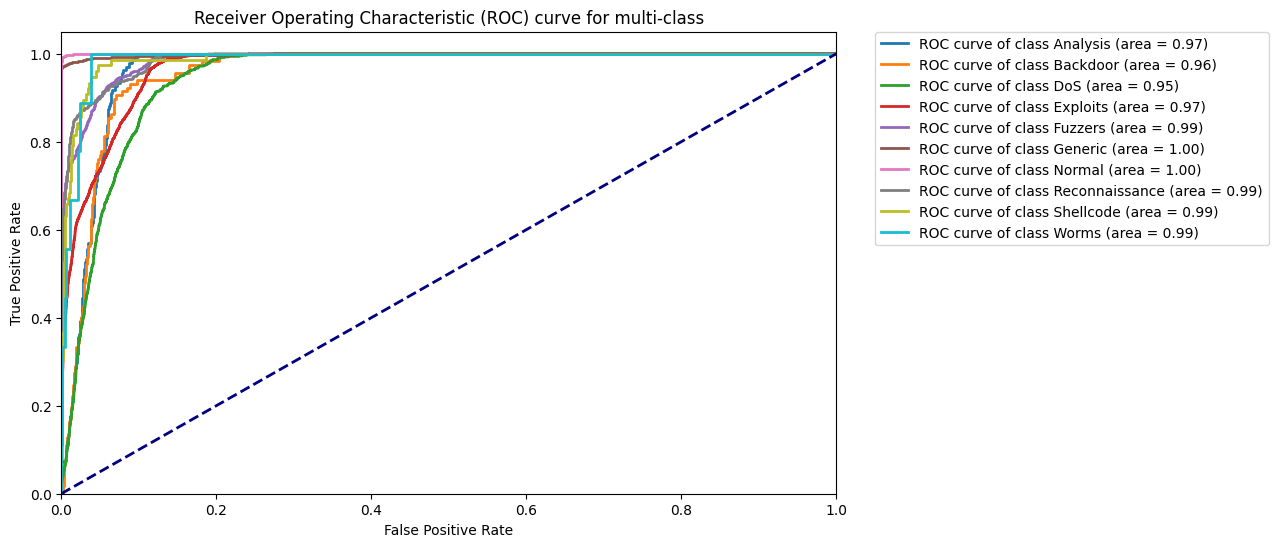

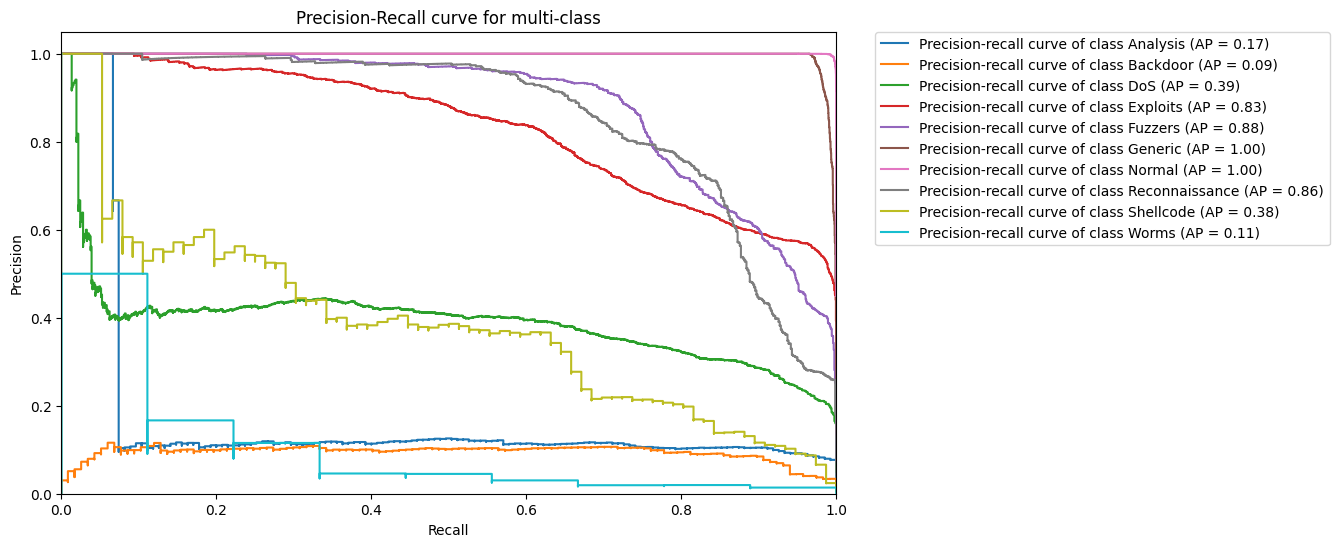

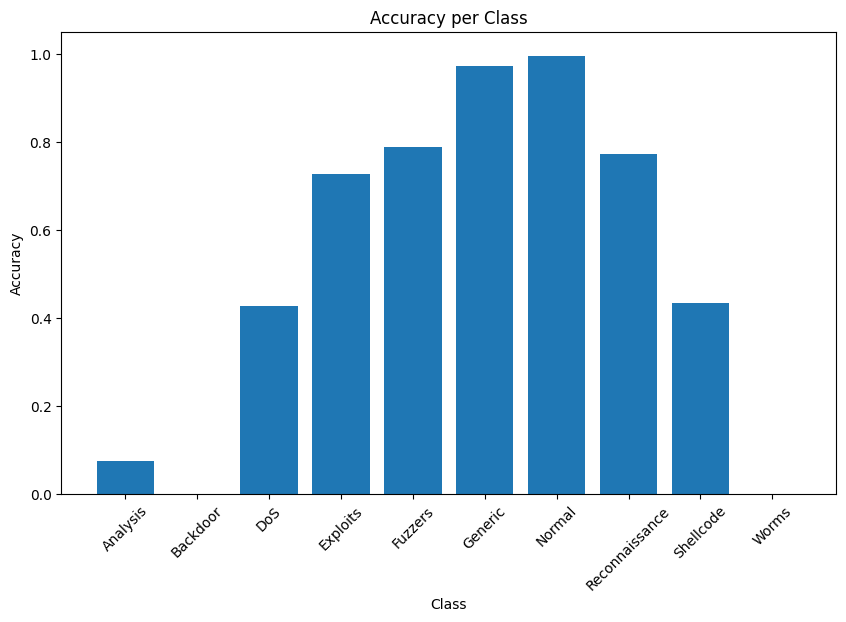

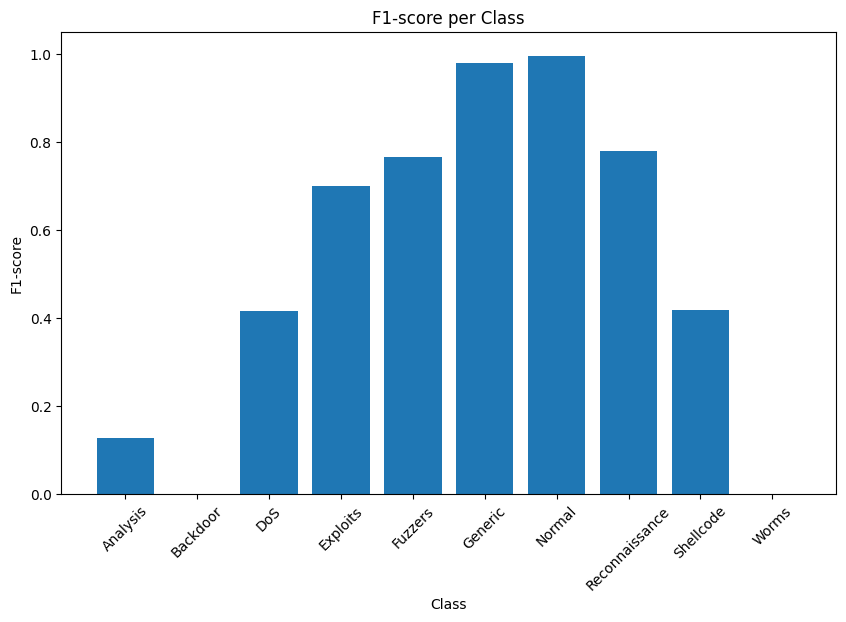

In [8]:
# # Calculate prediction probabilities
y_score = model.predict(X_test)


model_name = "Transformer"
# Print scores
print_score(y_pred, y_test, y_score, le, model_name)
plot_roc_curve(y_test, y_score, le, model_name)
plot_precision_recall_curve(y_test, y_score, le, model_name)
plot_class_accuracy(y_test, y_pred, le, model_name)
plot_class_f1_score(y_test, y_pred, le, model_name)

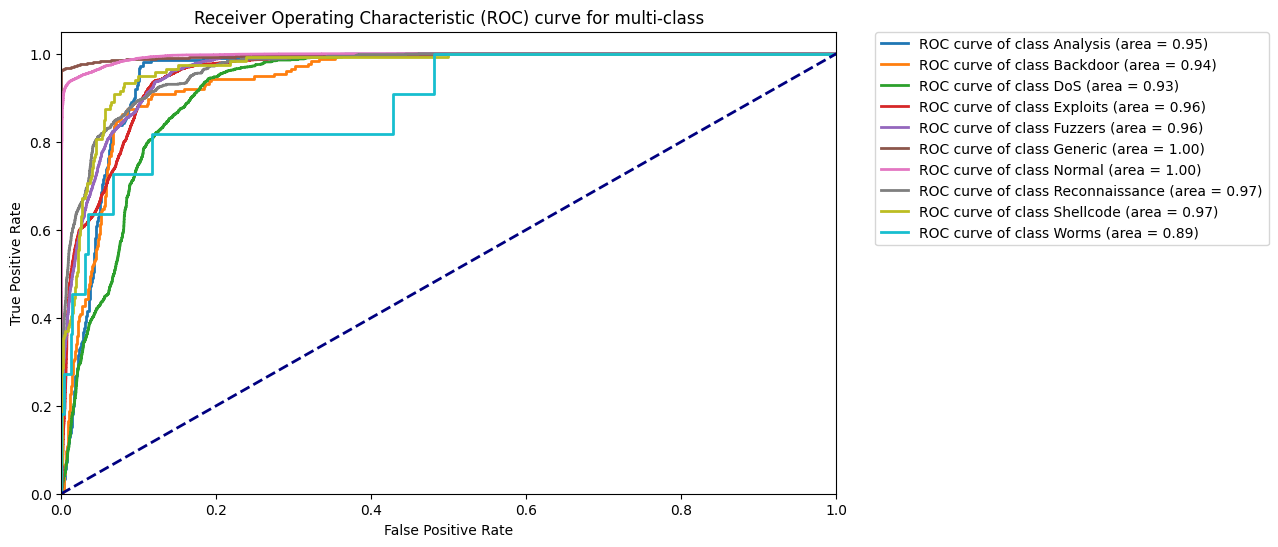

SVM 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is i

,Metric,Value
0,Accuracy,0.841093
1,Precision (macro),0.421600
2,Recall (macro),0.405908
3,F1-score (macro),0.411477
4,AUC-ROC (macro),0.956151
5,Precision (Analysis),0.000000
6,Recall (Analysis),0.000000
7,F1-score (Analysis),0.000000
8,Precision (Backdoor),0.000000
9,Recall (Backdoor),0.000000


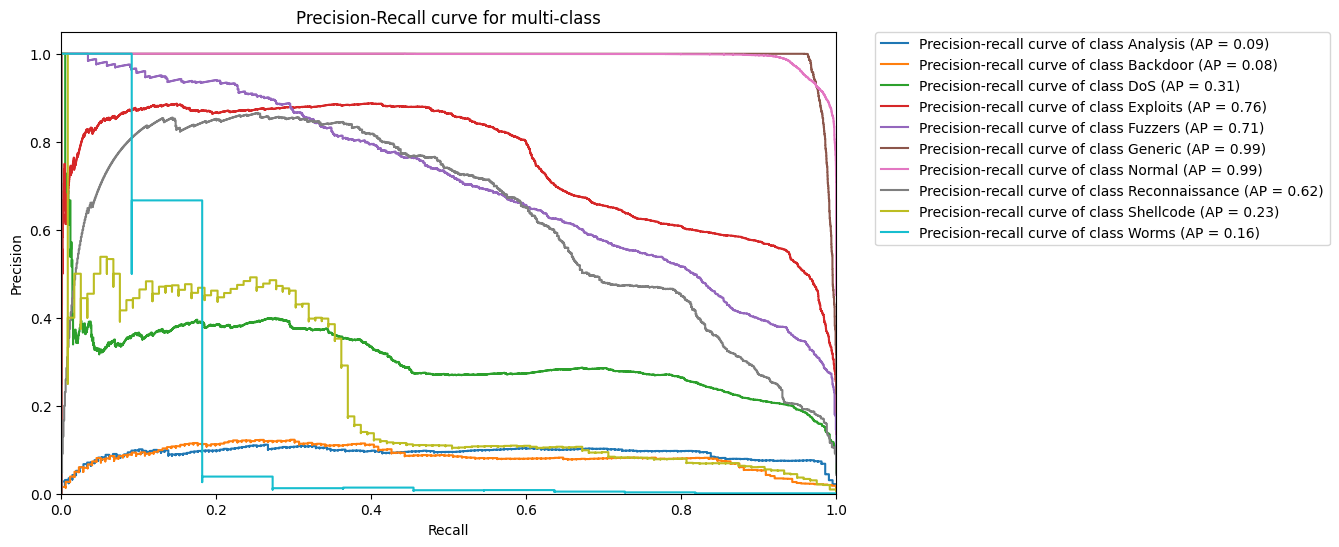

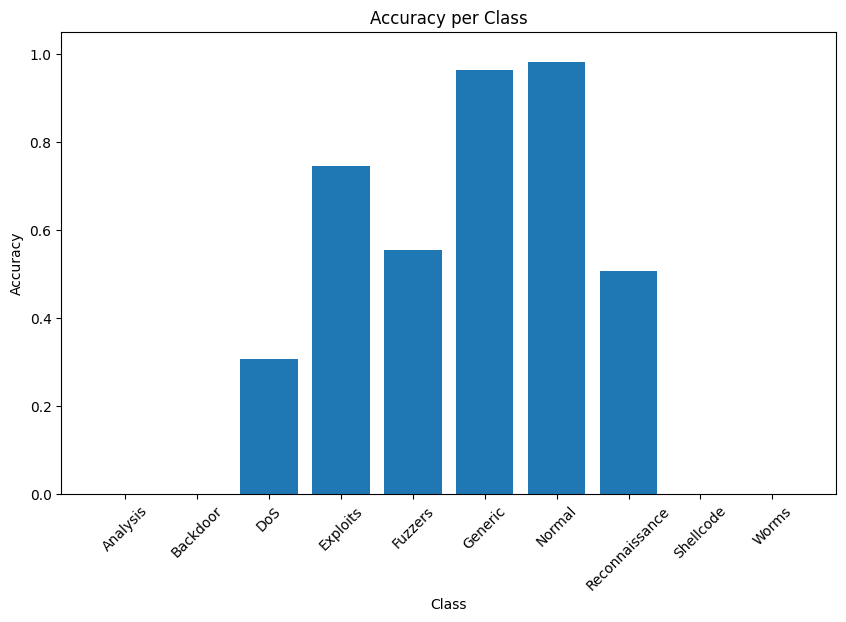

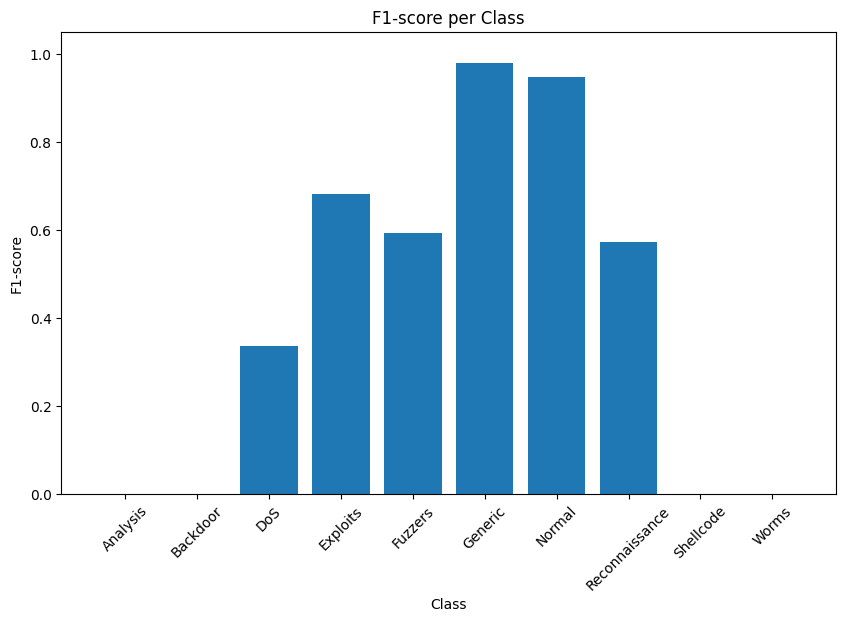

In [ ]:
from sklearn.svm import SVC
# Convert categorical variables to dummy variables
cat_columns = ['proto', 'service', 'state']
df = pd.get_dummies(df, columns=cat_columns)

# Split the dataset into features and target
X = df.drop(['attack_cat', 'label'], axis=1)
y = df['attack_cat']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM Classifier
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test_scaled)

# Plot ROC curve
y_score = svm_classifier.predict_proba(X_test_scaled)

model_name = 'SVM'
plot_roc_curve(y_test, y_score, label_encoder, model_name)
# Print scores
print("SVM ")
print_score(y_pred, y_test, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

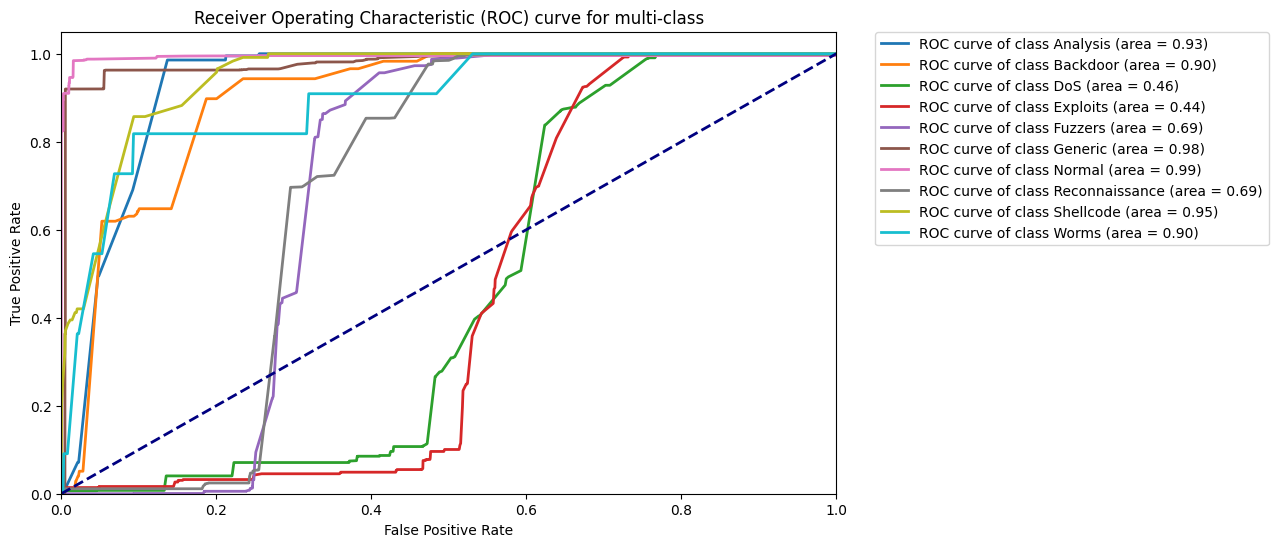

Adaboost 


,Metric,Value
0,Accuracy,0.789919
1,Precision (macro),0.382420
2,Recall (macro),0.411691
3,F1-score (macro),0.391747
4,AUC-ROC (macro),0.792577
5,Precision (Analysis),0.000000
6,Recall (Analysis),0.000000
7,F1-score (Analysis),0.000000
8,Precision (Backdoor),0.000000
9,Recall (Backdoor),0.000000


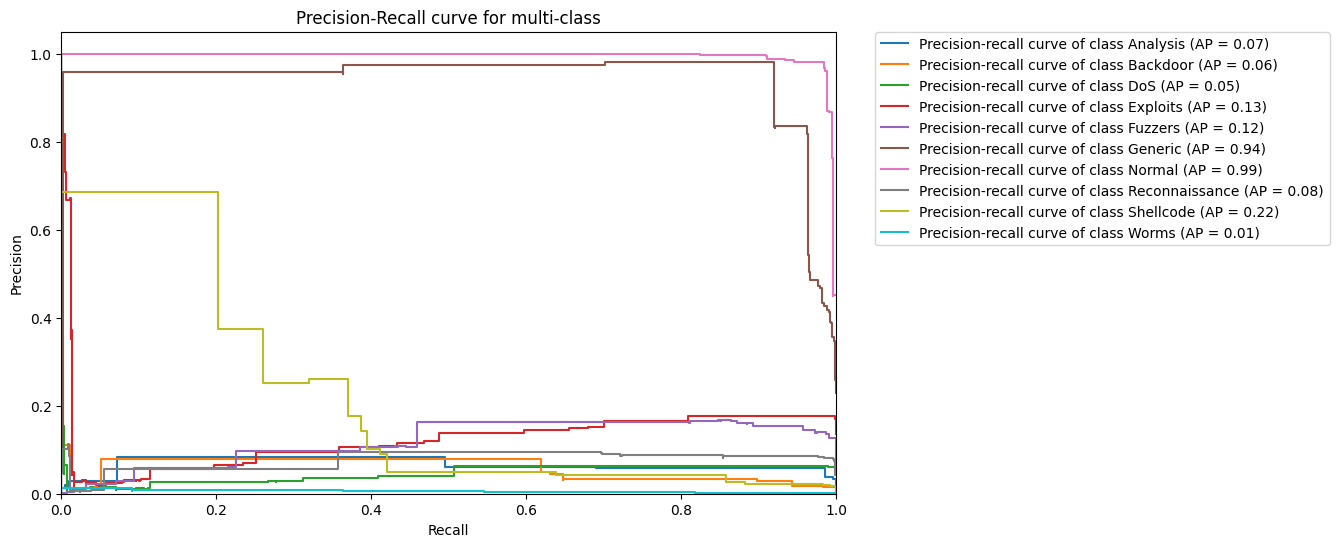

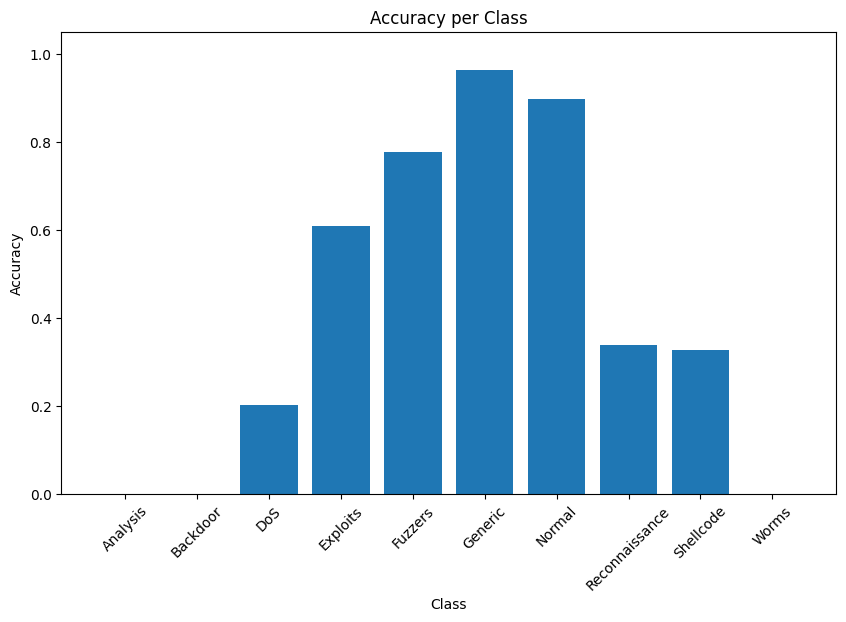

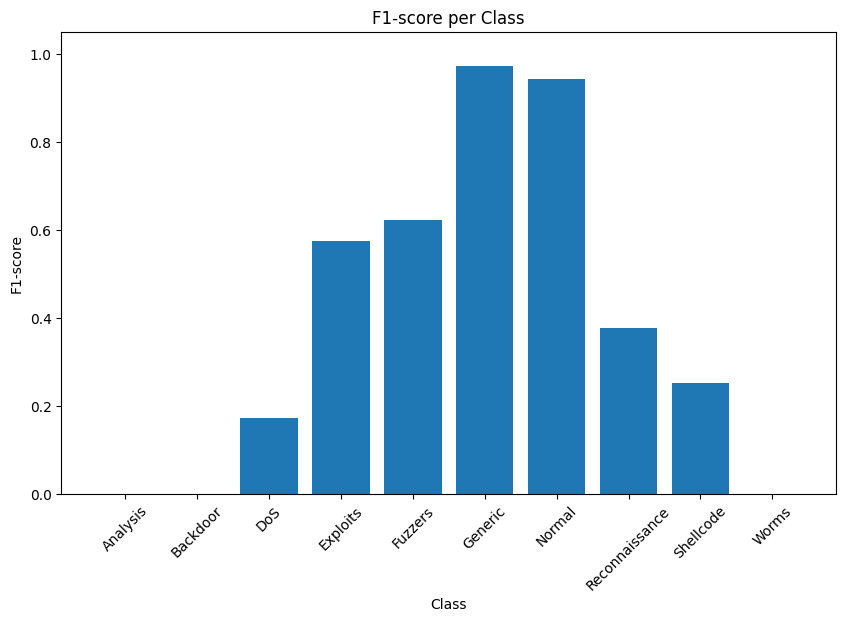

In [ ]:
# from sklearn.ensemble import AdaBoostClassifier

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# y = df['attack_cat']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# # Train the AdaBoost Classifier
# adaboost_classifier = AdaBoostClassifier(random_state=42)
# adaboost_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = adaboost_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = adaboost_classifier.predict_proba(X_test_scaled)
# model_name = 'Adaboost'
# plot_roc_curve(y_test, y_score, label_encoder, model_name)

# print("Adaboost ")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

In [ ]:
# import tensorflow as tf

# embedding_size = 128  # Choose the desired embedding size
# X = df.iloc[:, :-1]  # Get all columns except the last one as input features
# num_features = X.shape[1]
# num_samples = X.shape[0]  # Get the number of samples

# # Define the input and embedding layer
# input_features = tf.keras.layers.Input(shape=(num_features,))
# embedding_layer = tf.keras.layers.Dense(embedding_size, activation='relu')
# embeddings = embedding_layer(input_features)

# # Positional encoding functions
# def get_angles(pos, i, d_model):
#     angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
#     return pos * angle_rates

# def positional_encoding(position, d_model):
#     angle_rads = get_angles(np.arange(position)[:, np.newaxis],
#                             np.arange(d_model)[np.newaxis, :],
#                             d_model)
#     pos_encoding = np.zeros((position, d_model), dtype=np.float32)
#     pos_encoding[0::2, :] = np.sin(angle_rads[0::2, :])
#     pos_encoding[1::2, :] = np.cos(angle_rads[1::2, :])
#     return tf.cast(pos_encoding, dtype=tf.float32)

# # Add positional encoding to the embeddings
# position = num_features  # Number of positions equal to the number of samples
# embeddings_with_pos_enc = positional_encoding(position, embedding_size) + embeddings


In [ ]:
# import tensorflow as tf
# print(tf.__version__)


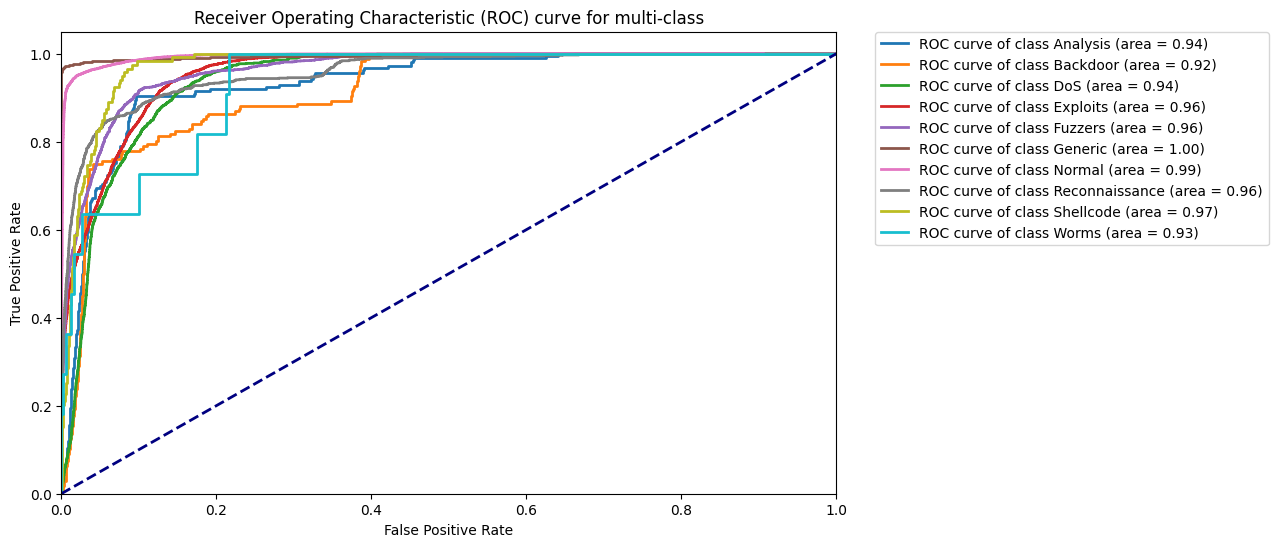

LogisticRegression Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Value
0,Accuracy,0.844170
1,Precision (macro),0.457225
2,Recall (macro),0.430673
3,F1-score (macro),0.430320
4,AUC-ROC (macro),0.956531
5,Precision (Analysis),0.200000
6,Recall (Analysis),0.019048
7,F1-score (Analysis),0.034783
8,Precision (Backdoor),0.000000
9,Recall (Backdoor),0.000000


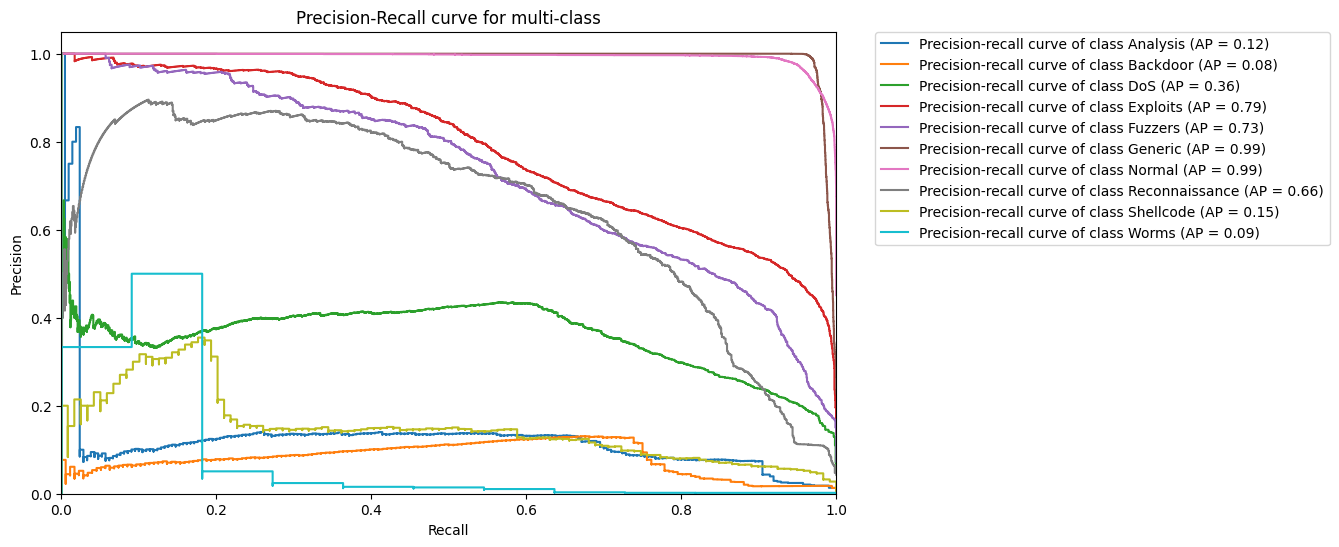

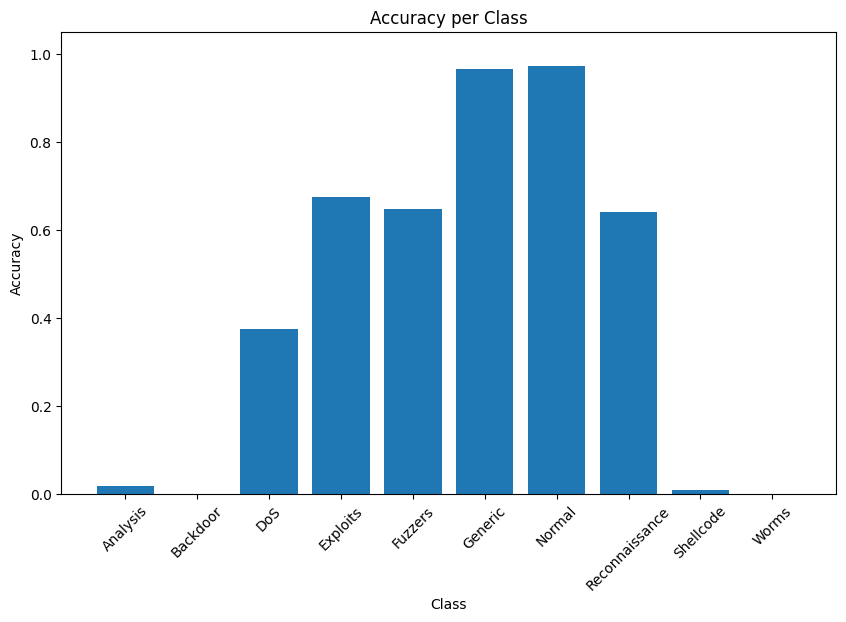

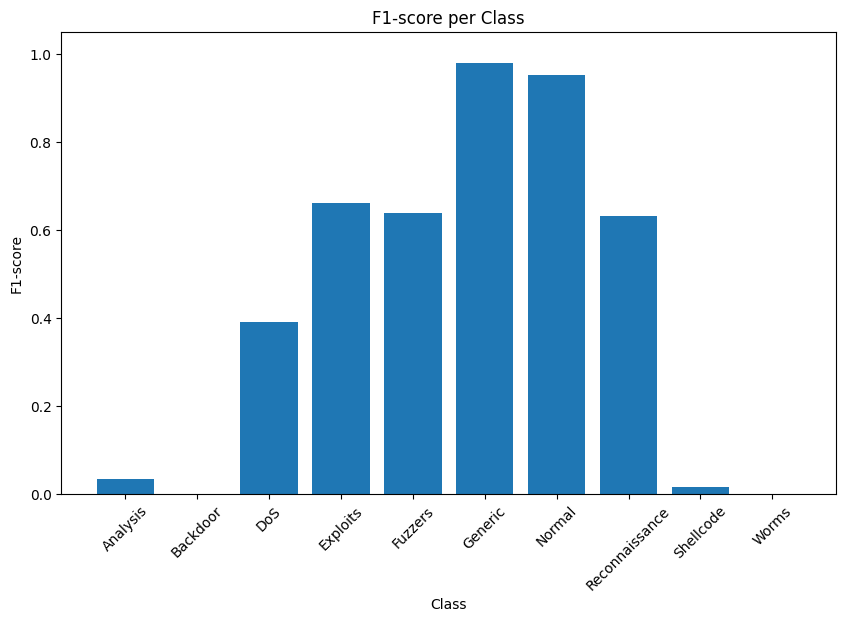

In [ ]:
# from sklearn.linear_model import LogisticRegression

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# y = df['attack_cat']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# # Train the Logistic Regression Classifier
# lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
# lr_classifier.fit(X_train_scaled, y_train)
# # Make predictions
# y_pred = lr_classifier.predict(X_test_scaled)
# # Plot ROC curve
# y_score = lr_classifier.predict_proba(X_test_scaled)

# model_name = 'LogisticRegression'
# plot_roc_curve(y_test, y_score, label_encoder, model_name)
# # Print scores
# print("LogisticRegression Classifier")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

Epoch 1/100
721/721 [==============================] - 6s 6ms/step - loss: 0.9662 - accuracy: 0.6994 - val_loss: 0.6294 - val_accuracy: 0.7747
Epoch 2/100
721/721 [==============================] - 4s 6ms/step - loss: 0.6471 - accuracy: 0.7720 - val_loss: 0.5577 - val_accuracy: 0.7934
Epoch 3/100
721/721 [==============================] - 4s 6ms/step - loss: 0.5825 - accuracy: 0.7931 - val_loss: 0.5210 - val_accuracy: 0.8170
Epoch 4/100
721/721 [==============================] - 4s 5ms/step - loss: 0.5474 - accuracy: 0.8056 - val_loss: 0.4846 - val_accuracy: 0.8276
Epoch 5/100
721/721 [==============================] - 4s 5ms/step - loss: 0.5222 - accuracy: 0.8136 - val_loss: 0.4677 - val_accuracy: 0.8342
Epoch 6/100
721/721 [==============================] - 4s 6ms/step - loss: 0.5095 - accuracy: 0.8181 - val_loss: 0.4596 - val_accuracy: 0.8367
Epoch 7/100
721/721 [==============================] - 4s 5ms/step - loss: 0.4915 - accuracy: 0.8257 - val_loss: 0.4510 - val_accuracy: 0.8401

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is i

,Metric,Value
0,Accuracy,0.867733
1,Precision (macro),0.429443
2,Recall (macro),0.430821
3,F1-score (macro),0.417632
4,AUC-ROC (macro),0.969429
5,Precision (Analysis),0.000000
6,Recall (Analysis),0.000000
7,F1-score (Analysis),0.000000
8,Precision (Backdoor),0.000000
9,Recall (Backdoor),0.000000


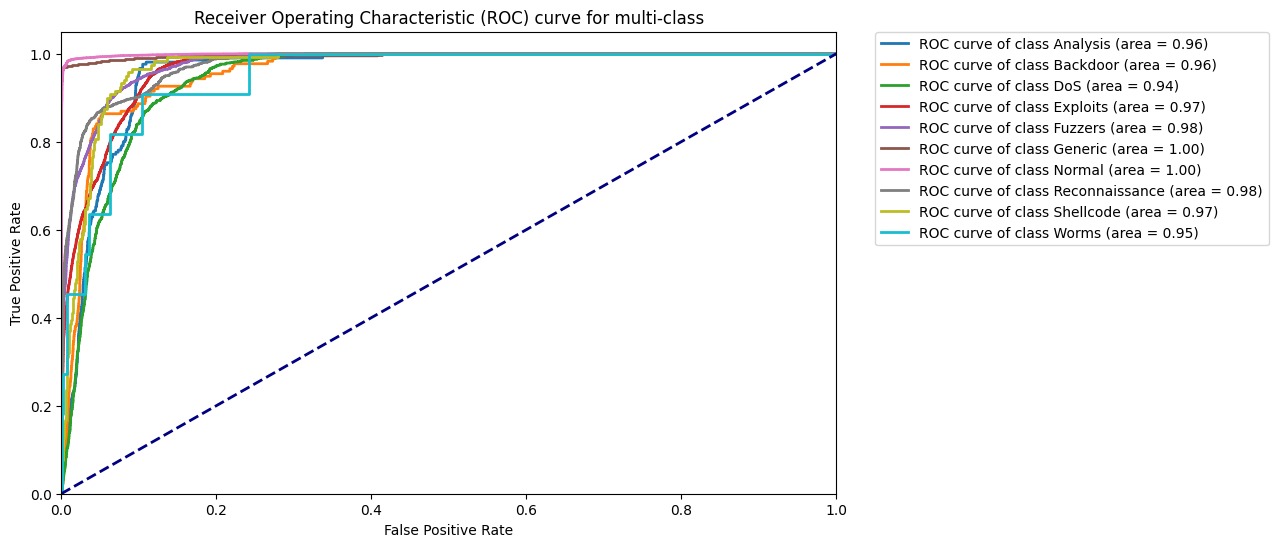

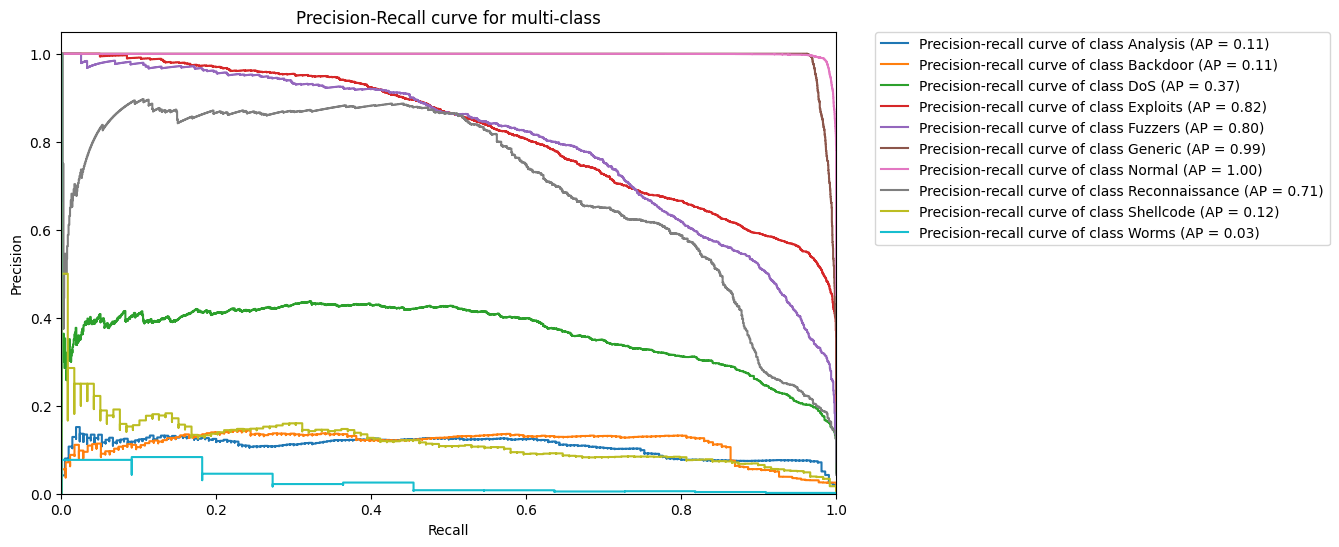

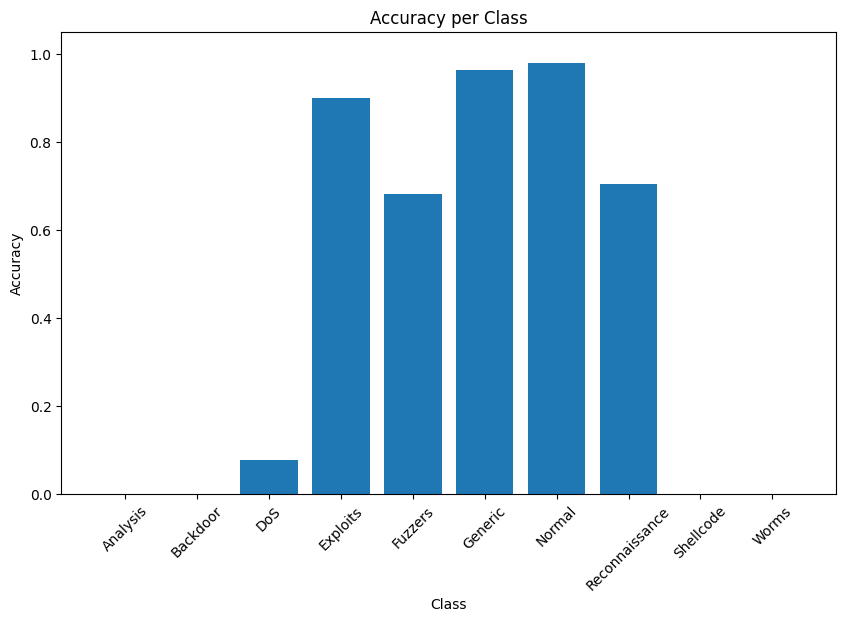

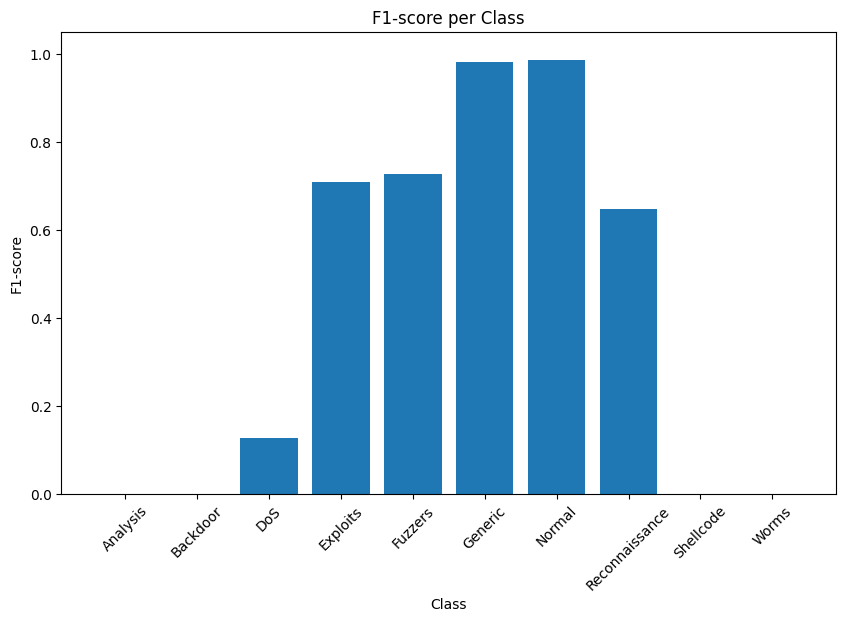

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import EarlyStopping


# model_name = 'LSTM'

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# y = df['attack_cat']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # One-hot encode the target variable for use with a CNN
# y_onehot = to_categorical(y_encoded)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# # Reshape the input data into 3D format for use with LSTM (samples, timesteps, features)
# # Ensure that the data is reshaped appropriately for a time series dataset
# timesteps = 1  # Modify this value based on the dataset's structure
# X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1])
# X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1])

# # Define the LSTM architecture
# model = Sequential()
# model.add(LSTM(32, activation='relu', input_shape=(timesteps, X_train_scaled.shape[2])))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
# # Train the model
# model.fit(X_train_scaled, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])


# # Make predictions
# y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# # Calculate prediction probabilities
# y_score = model.predict(X_test_scaled)

# # Convert one-hot encoded y_test to class labels
# y_test_labels = np.argmax(y_test, axis=-1)

# # Print scores
# print_score(y_pred, y_test_labels, y_score, label_encoder, model_name)
# plot_roc_curve(y_test_labels, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test_labels, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test_labels, y_pred, label_encoder, model_name)

reducing the majority classes in the CIC_IDS_2017 dataset by 75 percent actually marginally improved detection of minority classes

Epoch 1/50
721/721 [==============================] - 15s 5ms/step - loss: 0.6239 - accuracy: 0.7962 - val_loss: 0.4345 - val_accuracy: 0.8489
Epoch 2/50
721/721 [==============================] - 3s 4ms/step - loss: 0.4232 - accuracy: 0.8506 - val_loss: 0.3938 - val_accuracy: 0.8574
Epoch 3/50
721/721 [==============================] - 3s 4ms/step - loss: 0.3908 - accuracy: 0.8589 - val_loss: 0.3749 - val_accuracy: 0.8637
Epoch 4/50
721/721 [==============================] - 3s 4ms/step - loss: 0.3728 - accuracy: 0.8635 - val_loss: 0.3610 - val_accuracy: 0.8618
Epoch 5/50
721/721 [==============================] - 3s 4ms/step - loss: 0.3600 - accuracy: 0.8663 - val_loss: 0.3582 - val_accuracy: 0.8636
Epoch 6/50
721/721 [==============================] - 3s 4ms/step - loss: 0.3521 - accuracy: 0.8701 - val_loss: 0.3504 - val_accuracy: 0.8680
Epoch 7/50
721/721 [==============================] - 3s 4ms/step - loss: 0.3464 - accuracy: 0.8708 - val_loss: 0.3409 - val_accuracy: 0.8706
Epoch

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Value
0,Accuracy,0.887449
1,Precision (macro),0.599081
2,Recall (macro),0.482082
3,F1-score (macro),0.493471
4,AUC-ROC (macro),0.979121
5,Precision (Analysis),0.684211
6,Recall (Analysis),0.061905
7,F1-score (Analysis),0.113537
8,Precision (Backdoor),0.000000
9,Recall (Backdoor),0.000000


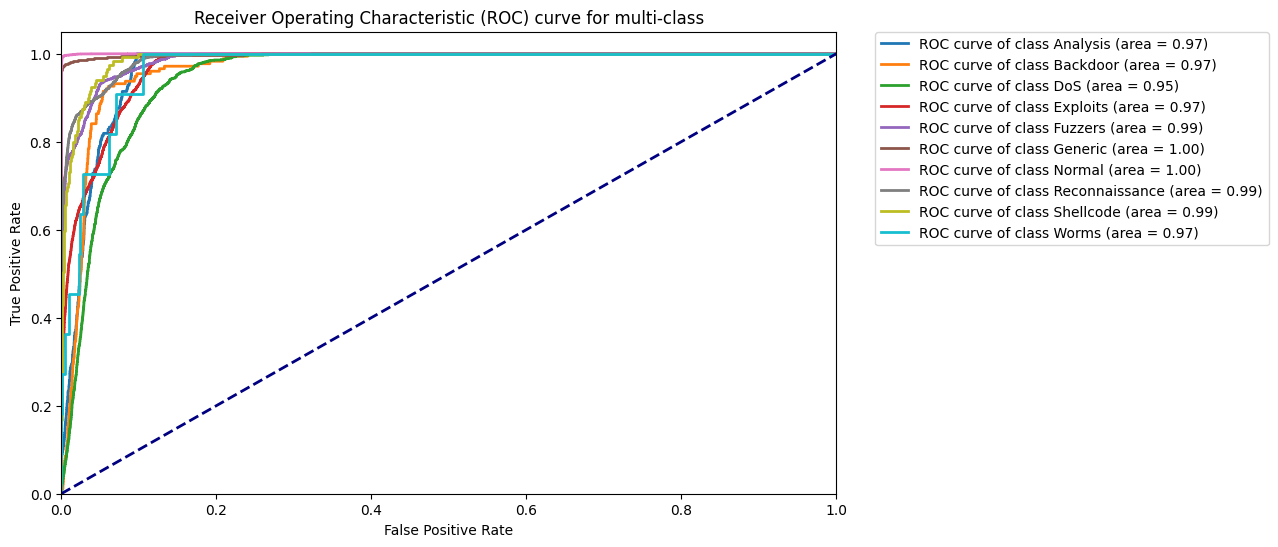

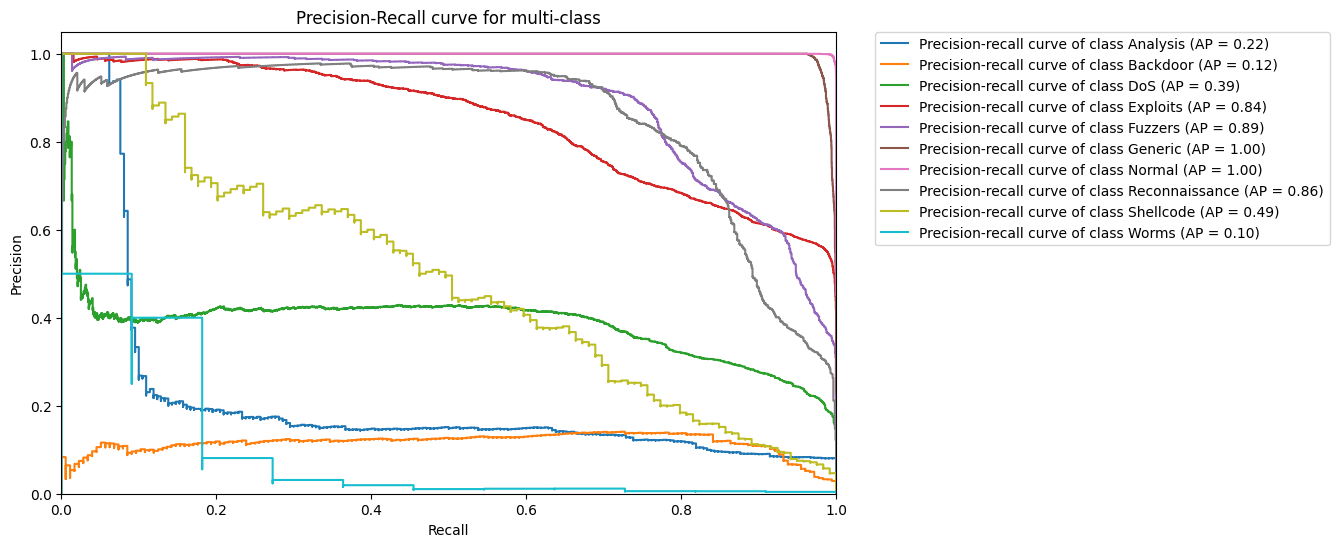

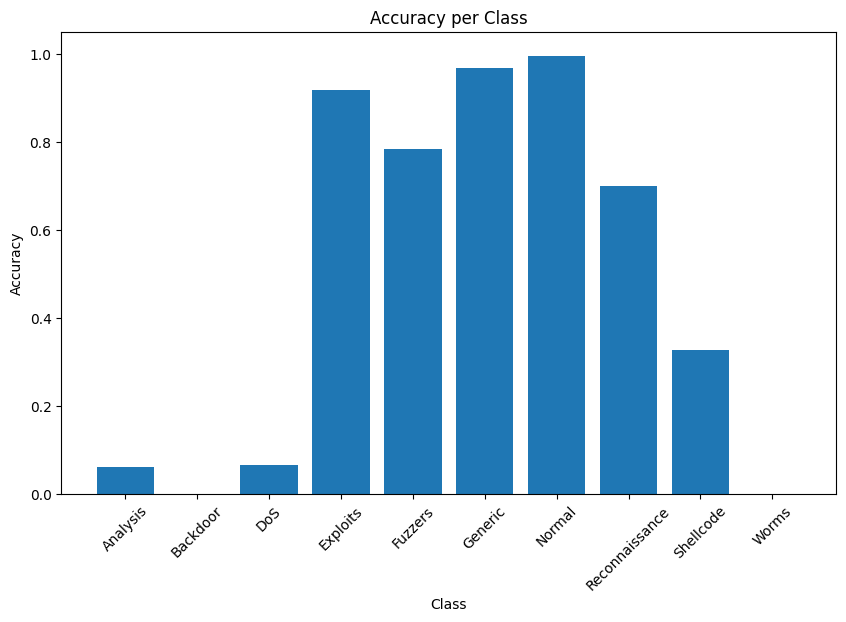

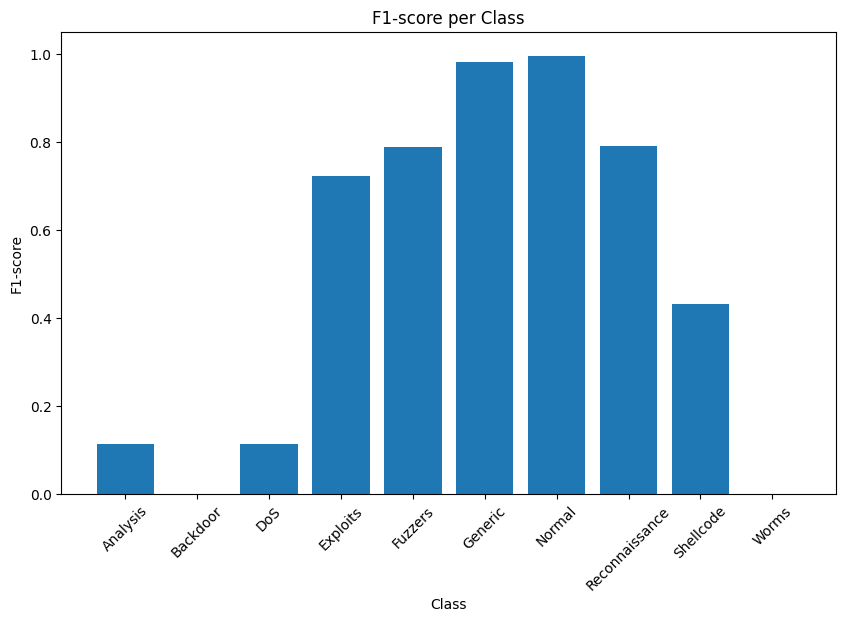

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import EarlyStopping



# model_name = 'CNN'

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# y = df['attack_cat']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # One-hot encode the target variable for use with a CNN
# y_onehot = to_categorical(y_encoded)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Reshape the input data into 3D format for use with Conv1D (samples, timesteps, features)
# X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
# X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


# # Define the CNN architecture
# model = Sequential()
# model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
# # Train the model
# model.fit(X_train_scaled, y_train, batch_size=64, epochs=50, validation_split=0.2,  callbacks=[early_stopping])
# # Evaluate the model
# score = model.evaluate(X_test_scaled, y_test)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])
# # Make predictions
# y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# # Calculate prediction probabilities
# y_score = model.predict(X_test_scaled)

# # Convert one-hot encoded y_test to class labels
# y_test_labels = np.argmax(y_test, axis=-1)
# model_name = "CNN"
# # Print scores
# print_score(y_pred, y_test_labels, y_score, label_encoder, model_name)
# plot_roc_curve(y_test_labels, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test_labels, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test_labels, y_pred, label_encoder, model_name)

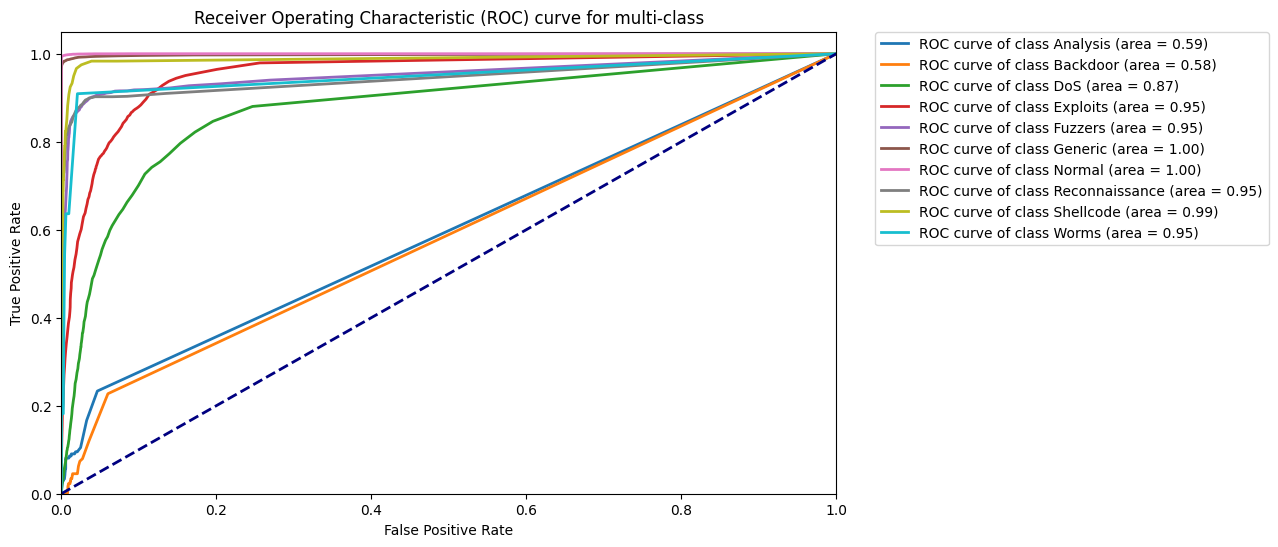

Random Forest Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Value
0,Accuracy,0.893968
1,Precision (macro),0.552543
2,Recall (macro),0.535715
3,F1-score (macro),0.543087
4,AUC-ROC (macro),0.883667
5,Precision (Analysis),0.096154
6,Recall (Analysis),0.071429
7,F1-score (Analysis),0.081967
8,Precision (Backdoor),0.000000
9,Recall (Backdoor),0.000000


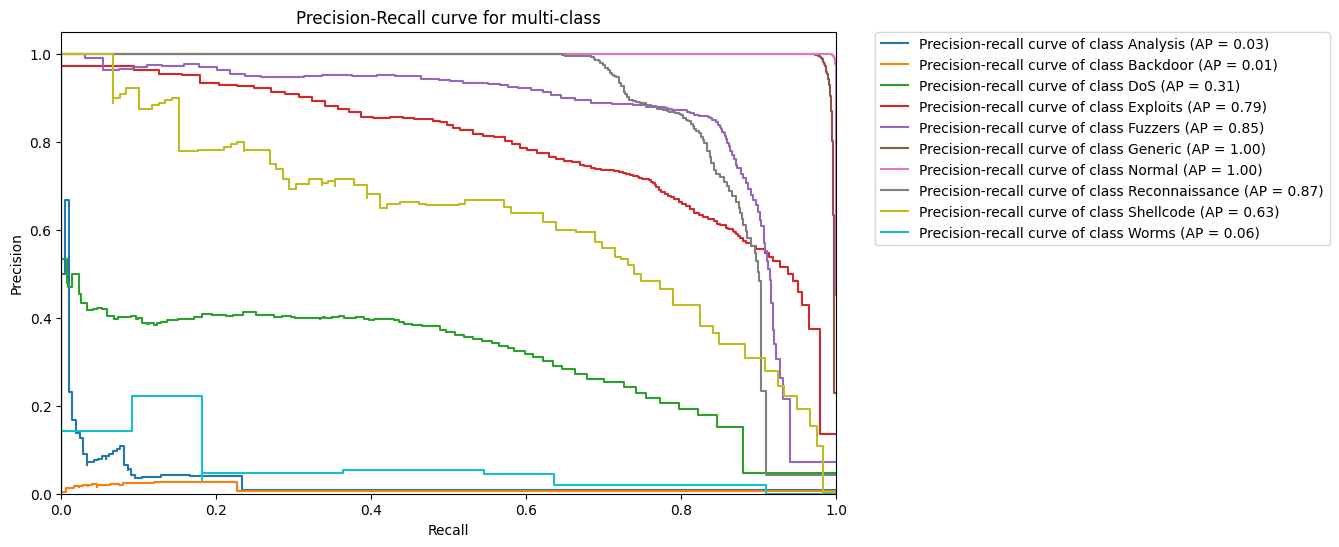

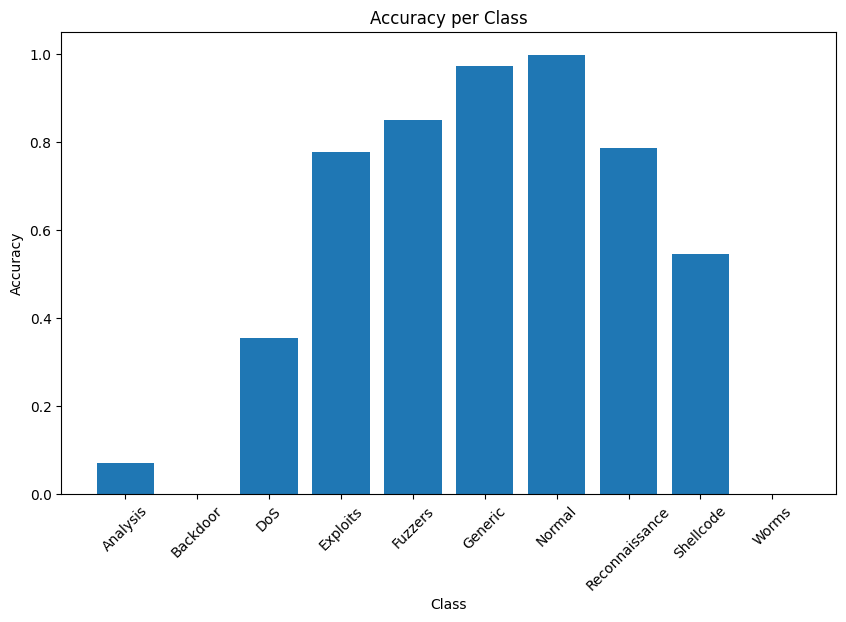

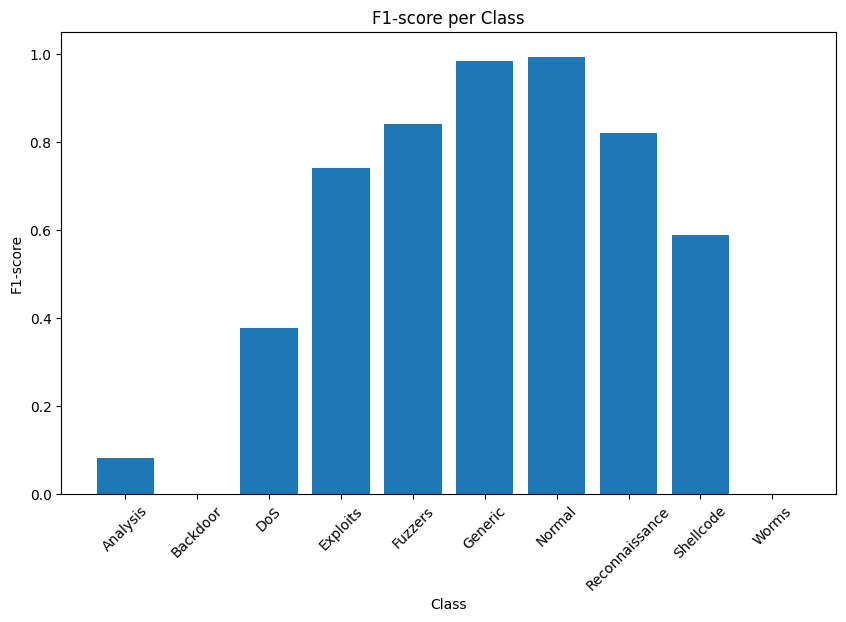

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# y = df['attack_cat']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Train the Random Forest Classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = rf_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = rf_classifier.predict_proba(X_test_scaled)

# model_name = 'RandomForest'
# plot_roc_curve(y_test, y_score, label_encoder, model_name)
# # Print scores
# print("Random Forest Classifier")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

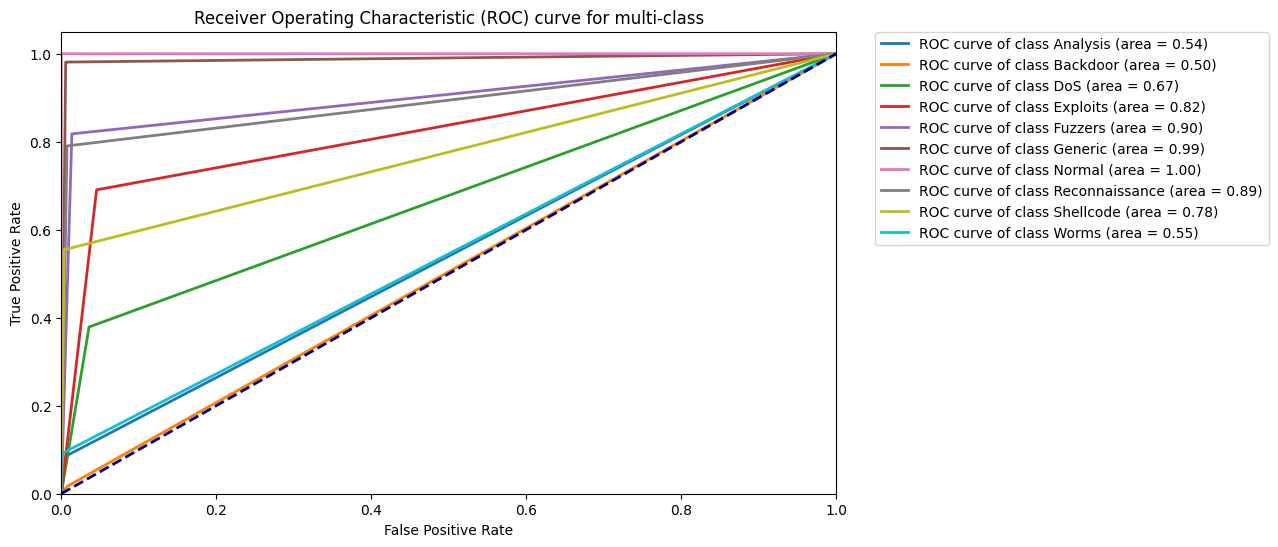

DecisionTree Classifier


,Metric,Value
0,Accuracy,0.884251
1,Precision (macro),0.532708
2,Recall (macro),0.540713
3,F1-score (macro),0.535532
4,AUC-ROC (macro),0.764035
5,Precision (Analysis),0.105882
6,Recall (Analysis),0.085714
7,F1-score (Analysis),0.094737
8,Precision (Backdoor),0.015152
9,Recall (Backdoor),0.017045


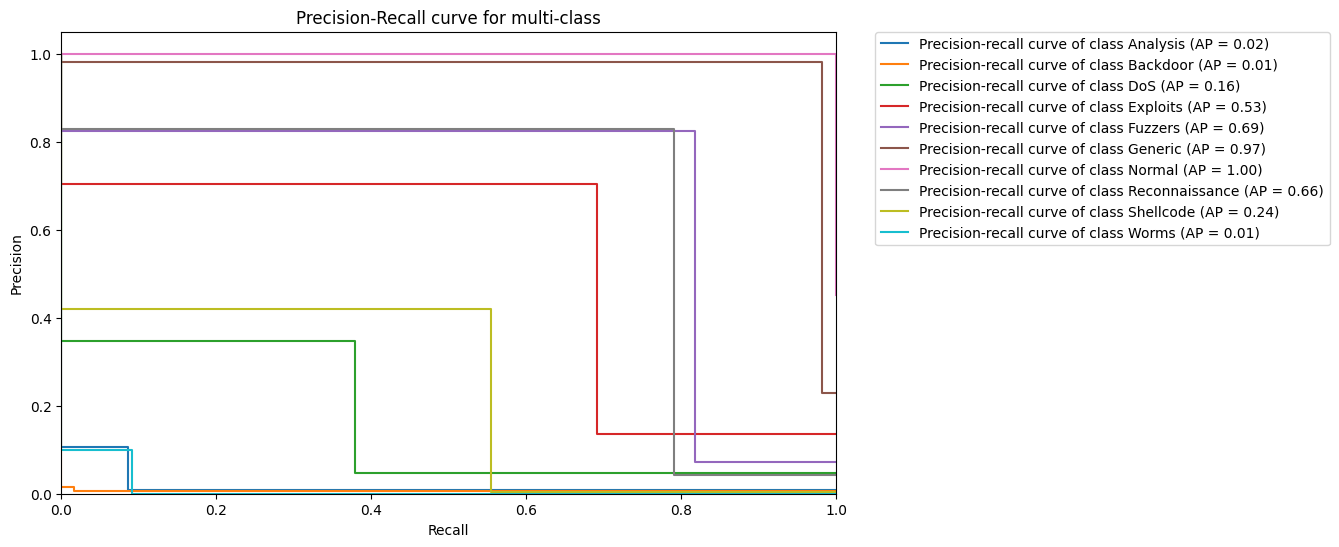

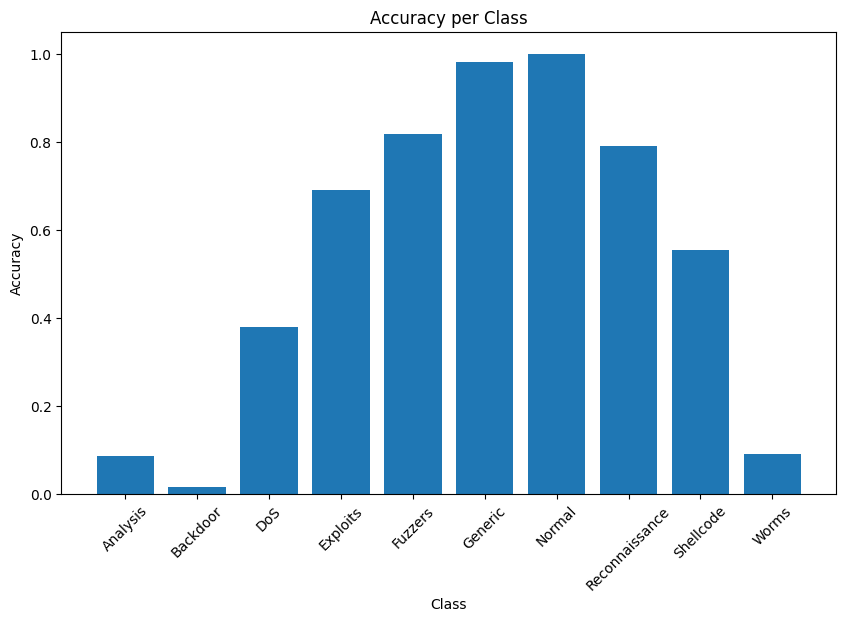

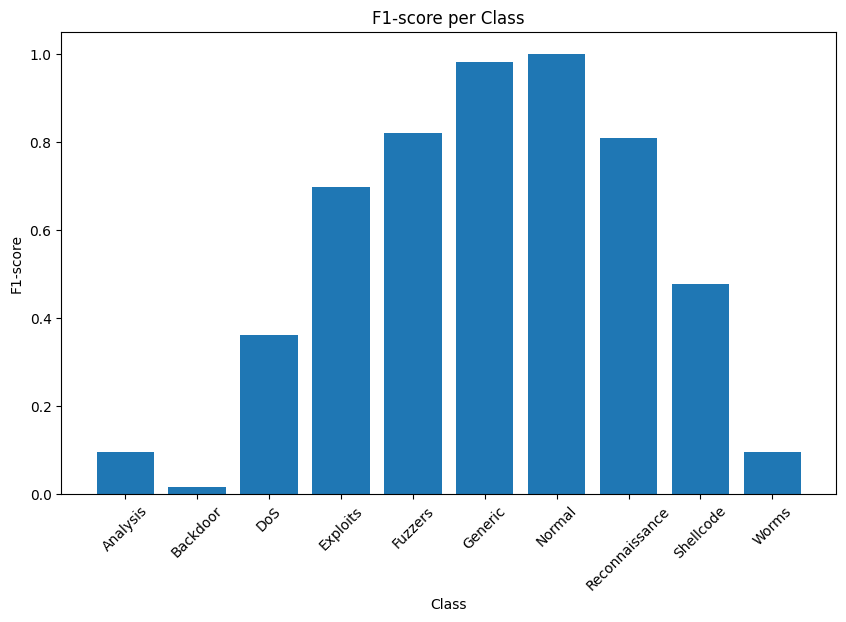

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# # Train the Decision Tree Classifier
# model_name = 'DecisionTree'

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# y = df['attack_cat']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# dt_classifier = DecisionTreeClassifier(random_state=42)
# dt_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = dt_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = dt_classifier.predict_proba(X_test_scaled)

# model_name = 'DecisionTree'
# plot_roc_curve(y_test, y_score, label_encoder, model_name)
# # Print scores
# print("DecisionTree Classifier")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)